In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import random
import os
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Colab_Notebooks/ECSE415_Final_Project/'

Mounted at /content/drive


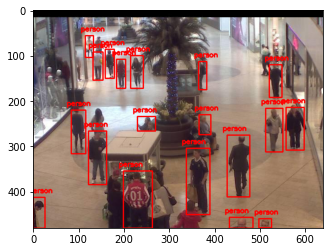

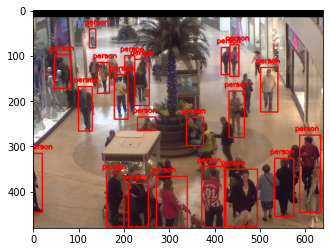

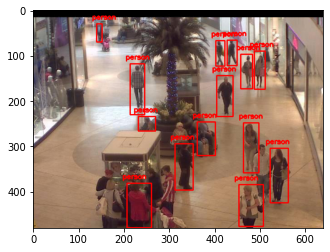

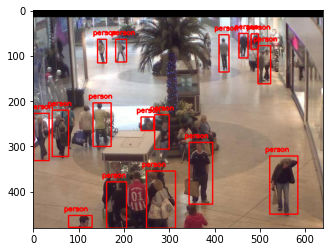

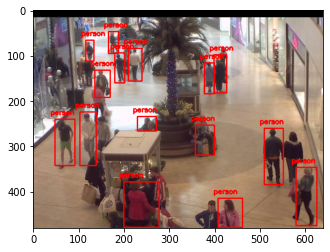

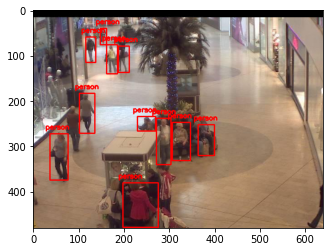

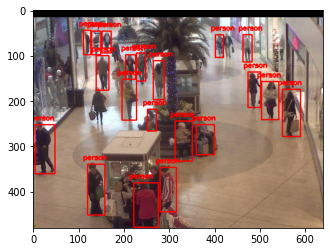

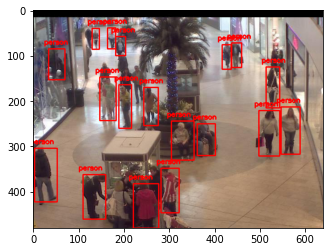

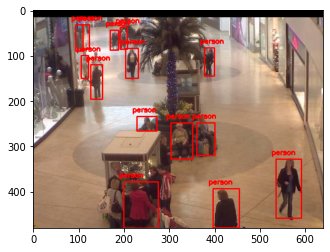

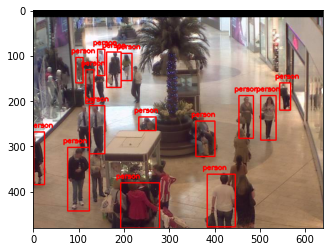

Detected people in 10 frames which are stored in the detected_images array
Extracted 345 positive patches which are stored in the positive_patches array


In [6]:
# Inspired from https://medium.com/@luanaebio/detecting-people-with-yolo-and-opencv-5c1f9bc6a810

images = []
path_frames = path + 'frames/'
detected_frames = []
positive_patches = []
negative_patches = []

for count,image_path in enumerate(os.listdir(path_frames)):
  if count > 9:
    break
  input_path = os.path.join(path_frames, image_path)
  image = plt.imread(input_path)
  images.append(image)

classes = None
with open(path + 'coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

Width = image.shape[1]
Height = image.shape[0]

# read pre-trained model and config file
net = cv2.dnn.readNet(path + 'yolov3.weights', path + 'cfg/yolov3.cfg')

for image in images:
  image_patches = image.copy()
  # create input blob 
  # set input blob for the network
  net.setInput(cv2.dnn.blobFromImage(image, 0.00392, (416,416), (0,0,0), True, crop=False))

  # run inference through the network
  # and gather predictions from output layers

  layer_names = net.getLayerNames()
  output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
  outs = net.forward(output_layers)


  class_ids = []
  confidences = []
  boxes = []

  #create bounding box 
  for out in outs:
      for detection in out:
          scores = detection[5:]
          class_id = np.argmax(scores)
          confidence = scores[class_id]
          if confidence > 0.1:
              center_x = int(detection[0] * Width)
              center_y = int(detection[1] * Height)
              w = int(detection[2] * Width)
              h = int(detection[3] * Height)
              x = center_x - w / 2
              y = center_y - h / 2
              positive_patch = np.squeeze(image_patches)
              positive_patch = positive_patch[int(y):int(y+h),int(x):int(x+w)]
              positive_patches.append(positive_patch)
              plt.imshow(positive_patch)
              plt.show()

              # Would need to generate negative patch here and append it to negative_patches array
              class_ids.append(class_id)
              confidences.append(float(confidence))
              boxes.append([x, y, w, h])


  indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.01, 0.01)

  #check if is people detection
  for i in indices:
      i = i[0]
      box = boxes[i]
      if class_ids[i]==0:
          label = str(classes[class_id]) 
          cv2.rectangle(image, (round(box[0]),round(box[1])), (round(box[0]+box[2]),round(box[1]+box[3])), (255, 0, 0), 2)
          cv2.putText(image, label, (round(box[0])-10,round(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

  detected_frames.append(image)
  plt.imshow(image)
  plt.show()

print('Detected people in ' + str(len(detected_frames)) + ' frames which are stored in the detected_images array')
print('Extracted ' + str(len(positive_patches)) + ' positive patches which are stored in the positive_patches array')

## Todo:
- Collecting negative patches
- Computing HoG features
- Feeding pos/neg patches to SVM
- Implement SVM
- Duplicate elimination
- Test it